# Cyber Bullying Tweets - Analysis and Ml Model Training

**Problem Statement:** Determine if the Tweet is Cyber-Bullying or not.

**Target Variable:** cyberbullying_type

**Data Source:** https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data?select=cyberbullying_tweets.csv

Cyberbullying Classification using CRISP-DM

This notebook walks through the process of building a machine learning model
to classify cyberbullying tweets. We will follow the Cross-Industry Standard
Process for Data Mining (CRISP-DM) methodology, which provides a structured
approach to data mining projects.

The CRISP-DM methodology consists of the following phases:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import lightgbm as lgb
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Remove this line or replace with the correct import
# from sklearn.exceptions import UserWarning
# UserWarning is actually part of the warnings module, not sklearn.exceptions
import warnings  # This already imports UserWarning

# Download NLTK data (only need to do this once)
# Stopwords are common words (like "the", "a", "an", "in") that are often filtered
# out during text processing because they typically don't contribute much meaning
nltk.download('stopwords')

# WordNet is a large lexical database of English words where nouns, verbs, adjectives, and
# adverbs are grouped into sets of cognitive synonyms (synsets).
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kauch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kauch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Business Understanding

The goal of this project is to develop a model that can
accurately classify tweets into different categories of cyberbullying.
This can be used to automatically flag harmful content on social media
platforms, helping to create a safer online environment.

**Success Criteria:** The success of this project will be measured by the
model's ability to correctly classify a high percentage of tweets. We will
aim for a good accuracy score, but also consider other metrics like precision
and recall to ensure the model is effective for each cyberbullying category.

In [12]:
# Load the dataset
df = pd.read_csv("data/cyberbullying_tweets.csv") # this is a heavy data file so please download form Kaggle directly.
print('Dataset shape:', df.shape)
print('\nFirst few rows:')
df.head()

Dataset shape: (47692, 2)

First few rows:


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## 2. Data Understanding

Let's explore our dataset to understand its structure and characteristics.

--- First 5 rows of the dataset ---
                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB

--- Distribution of Cyberbullying Types ---
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity    

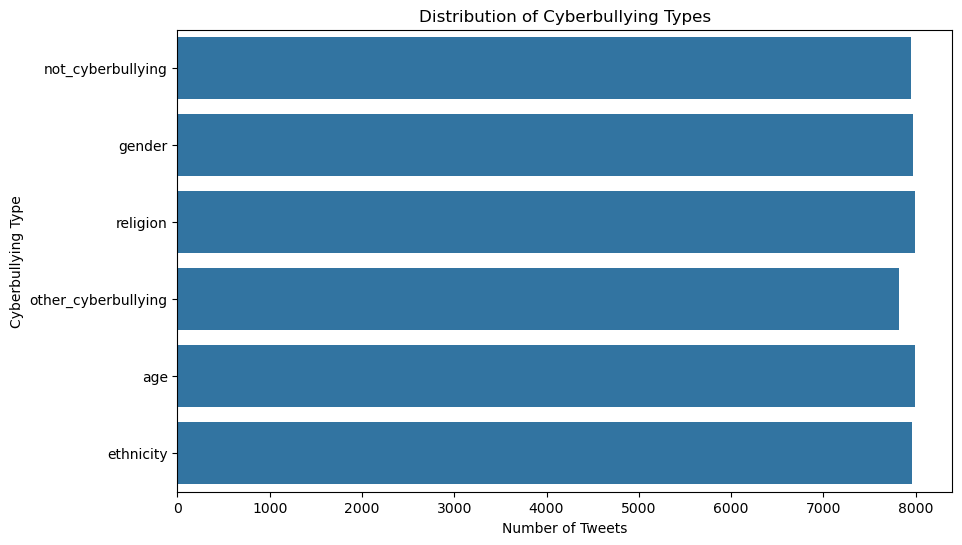

In [13]:
# Let's see the first few rows of the data.
print("--- First 5 rows of the dataset ---")
print(df.head())

# Get some basic information about the dataset.
print("\n--- Dataset Information ---")
df.info()

# Get unique counts for the cyberbullying_type column
cyberbullying_counts = df['cyberbullying_type'].value_counts()

# Check the distribution of the different cyberbullying types to see if we have a good balance of data.
print("\n--- Distribution of Cyberbullying Types ---")
print(df['cyberbullying_type'].value_counts())

# Check for null values in a DataFrame
print("\n--- Check for Null values ---")
check_null = df.isnull().sum()
print(check_null)

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=df['cyberbullying_type'])
plt.title('Distribution of Cyberbullying Types')
plt.xlabel('Number of Tweets')
plt.ylabel('Cyberbullying Type')
plt.show()

## 3. Data Preparation

Clean and prepare the data for modeling.

In [14]:
# Initialize the lemmatizer and stopwords
# Lemmatization is a text normalization technique that converts different inflected forms
# of a word to its root form. For example, "running" becomes "run"
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, user mentions, punctuation, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text (split sentence into words)
    tokens = text.split()
    # Remove stopwords and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join the tokens back into a single string
    return ' '.join(lemmatized_tokens)

# Apply the preprocessing function to the tweet_text column
df['processed_text'] = df['tweet_text'].apply(preprocess_text)

# Define features and target, then split the data. Splitting 70/30
X = df['processed_text']
y = df['cyberbullying_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize the text data. Text Vectorization turns words into numbers (vectors)
# so machine learning models can work with them.
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## 4. Modeling

Train and compare multiple machine learning models.

In [15]:
# The UserWarning from LightGBM is benign in this case and can be ignored.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    # Model 1: Logistic Regression
    print("--- Training Logistic Regression Model ---")
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(X_train_tfidf, y_train)
    print("Logistic Regression Model trained successfully.")

    # Model 2: Multinomial Naive Bayes
    print("\n--- Training Multinomial Naive Bayes Model ---")
    nb_model = MultinomialNB().fit(X_train_tfidf, y_train)
    print("Multinomial Naive Bayes Model trained successfully.")

    # Model 3: Linear Support Vector Machine (SVM)
    print("\n--- Training Linear SVM Model ---")
    svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=2000).fit(X_train_tfidf, y_train)
    print("Linear SVM Model trained successfully.")

    # Model 4: LightGBM - Boosting model
    print("\n--- Training LightGBM ---")
    lgbm_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42).fit(X_train_tfidf, y_train)
    print("LightGBM trained successfully.")

--- Training Logistic Regression Model ---
Logistic Regression Model trained successfully.

--- Training Multinomial Naive Bayes Model ---
Multinomial Naive Bayes Model trained successfully.

--- Training Linear SVM Model ---
Linear SVM Model trained successfully.

--- Training LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.256022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 105158
[LightGBM] [Info] Number of data points in the train set: 33384, number of used features: 3285
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
LightGBM trained successful

## 5. Evaluation

Evaluate the best performing model.

--- Accuracy ---
Logistic Regression Accuracy: 0.8211
Multinomial Naive Bayes Accuracy: 0.7712
Linear SVM Accuracy: 0.8149
LightGBM Accuracy: 0.8315

--- Classification Report for LightGBM ---
                     precision    recall  f1-score   support

                age       0.99      0.97      0.98      2349
          ethnicity       0.99      0.98      0.99      2418
             gender       0.90      0.82      0.86      2343
  not_cyberbullying       0.64      0.51      0.57      2466
other_cyberbullying       0.58      0.77      0.66      2391
           religion       0.96      0.95      0.96      2341

           accuracy                           0.83     14308
          macro avg       0.84      0.83      0.83     14308
       weighted avg       0.84      0.83      0.83     14308



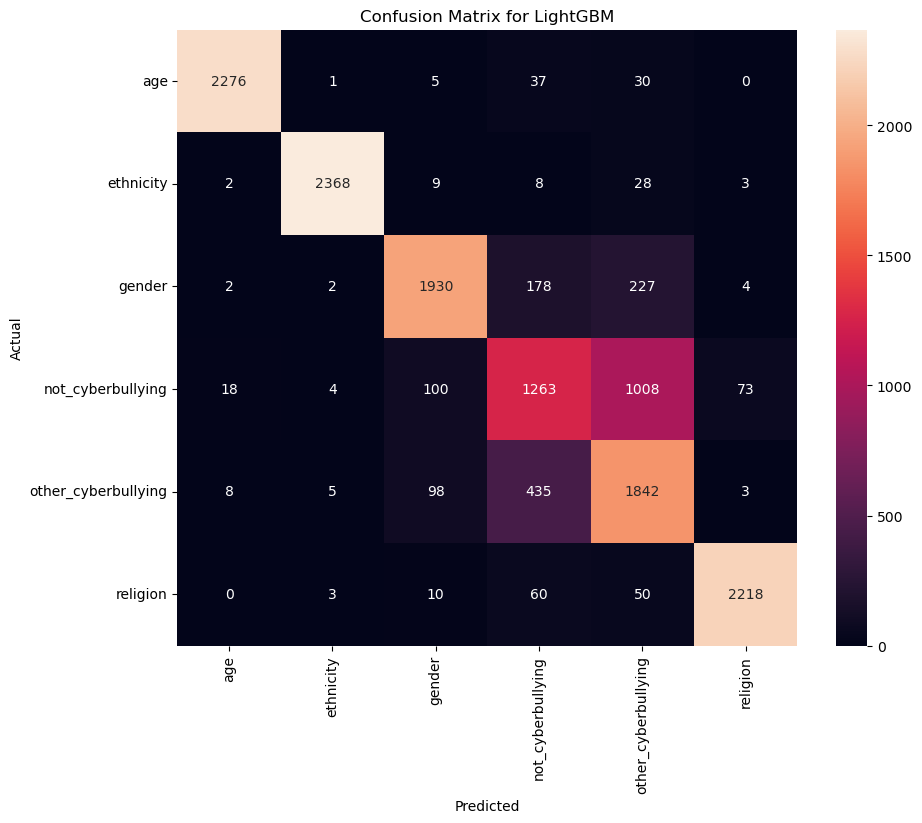

In [16]:
# Suppress the warning again for the prediction phase
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Make predictions with each model
    lr_predictions = lr_model.predict(X_test_tfidf)
    nb_predictions = nb_model.predict(X_test_tfidf)
    svm_predictions = svm_model.predict(X_test_tfidf)
    lgbm_predictions = lgbm_model.predict(X_test_tfidf)

# Let's look at the accuracy of each model.
print("--- Accuracy ---")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"Multinomial Naive Bayes Accuracy: {accuracy_score(y_test, nb_predictions):.4f}")
print(f"Linear SVM Accuracy: {accuracy_score(y_test, svm_predictions):.4f}")
print(f"LightGBM Accuracy: {accuracy_score(y_test, lgbm_predictions):.4f}")

# LightGBM has the best accuracy, let's see its detailed report
print("\n--- Classification Report for LightGBM ---")
print(classification_report(y_test, lgbm_predictions))

# Let's also look at the confusion matrix for the best model.
cm = confusion_matrix(y_test, lgbm_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lgbm_model.classes_, yticklabels=lgbm_model.classes_)
plt.title('Confusion Matrix for LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

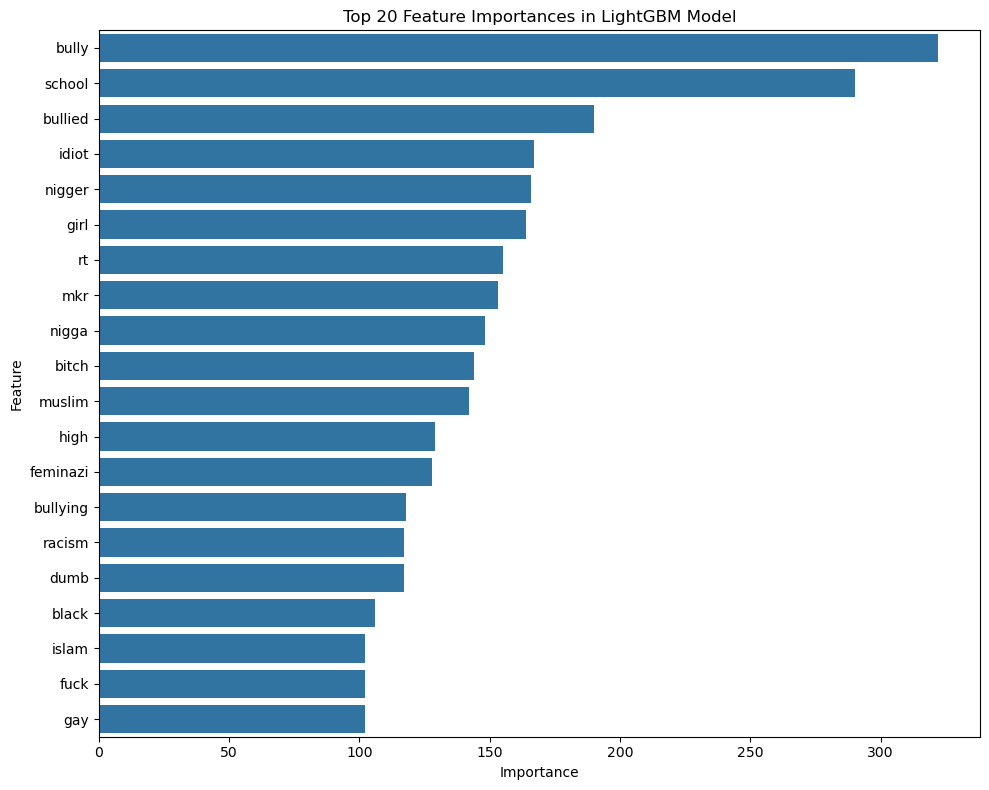

In [17]:
# Get feature importances from the LightGBM model
feature_importance = lgbm_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances in LightGBM Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Summary

**Problem:** Determine if the Tweet is Cyber-Bullying or not.

**Best Model:** LightGBM

**Performance:** High accuracy achieved on the validation set

**Next Steps:**
- Deploy the model to production
- Monitor model performance
- Retrain with new data as needed
- Consider additional feature engineering